#### A. Librerías, variables, funciones y lectura de datos.

In [35]:
#1. Importo librerías.
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
#2. Lectura de datos.
series_temporales = pd.read_csv("./inputs/dataset.csv")
diccionario = pd.read_excel("./inputs/diccionario.xlsx",sheet_name="metadata")

#### B. EDA.

In [ ]:
#1. Columnas y variables.
print("Tenemos {} columnas. Estas son: {}".format(series_temporales.shape[1],series_temporales.columns))

In [ ]:
#2. Información general de las variables.
series_temporales.info() 

# Tenemos series temporales con datos nulos......

In [ ]:
#3. Convertimos tipo de datos de la fecha a datetime y la ordenamos por dicha variable.
series_temporales["fecha"] = pd.to_datetime(series_temporales["fecha"])
series_temporales = series_temporales.sort_values("fecha")

In [ ]:
#4. Borramos filas enteras con NA.
series_temporales.dropna(inplace=True)

In [ ]:
#5. Entendemos las fechas de inicio y fin de la Serie temporal
inicio = series_temporales["fecha"].sort_values(ascending=True).iloc[0]
fin = series_temporales["fecha"].sort_values(ascending=False).iloc[0]

print(f"Las series temporales son algunas diarias, y otras mensuales, yendo desde {inicio} a {fin}.")

In [ ]:
#6. Tiene fechas repetidas?
print("Fechas unicas: {}".format(series_temporales["fecha"].nunique()))
print("Cantidad de filas totales: {}".format(series_temporales.shape[0]))

In [ ]:
#7. Entre el inicio y fin hay 170 fechas?
print("Tenemos una apertura de fechas de {} días".format(fin - inicio))
print("Debería cubrir {} días".format(series_temporales.shape[0]))

In [ ]:
#8. Que fechas faltan?
inicio = series_temporales["fecha"].min()
fin = series_temporales["fecha"].max()

rango_completo = pd.date_range(start=inicio, end=fin, freq='D')

fechas_reales = series_temporales["fecha"].unique()

fechas_faltantes = rango_completo.difference(fechas_reales)

print("Cantidad de fechas faltantes:", len(fechas_faltantes))
print("Fechas faltantes:")
print(fechas_faltantes)

# Tenemos fechas faltantes... las series temporales para considerarse tales tienen que ser constantes en sus intervalos.


In [ ]:
#9. Analisis estadísticos descriptivos básicos de las series temporales.
series_temporales.describe()

#### C. Análisis básicos en el Dominio del Tiempo.

In [ ]:
#1. Listamos las columnas numéricas (excluyendo 'fecha')
variables = series_temporales.drop(columns=["fecha"]).columns

#2. Graficamos cada variable en un gráfico separado
for var in variables:
    plt.figure(figsize=(12,5))  # Nueva figura para cada variable
    plt.plot(series_temporales["fecha"], series_temporales[var], marker='.')
    plt.title(f"Evolución de {var} en el tiempo")
    plt.xlabel("Fecha")
    plt.ylabel(var)
    plt.grid(True)
    plt.show()


#### D. Análisis en el Dominio de la Frecuencia (con TTF).

In [ ]:
#1. Iteramos sobre cada variable del diccionario para saber la frecuencia.
for _, row in diccionario.iterrows():
    var = row['serie']
    freq = row['frecuencia']  # 'diaria' o 'mensual'
    
    #2. Extramos los datos de la serie de dicha variable, en series_temporales.
    y = series_temporales[['fecha', var]].copy()
    y = y.set_index('fecha')
    
    #3. Reindexamos para que no haya "huecos" entre las fechas ----> Las ST para que funcione la TTF requiere que el delta t de las muestras sea constante.
    if freq == 'diaria':
        y = y.asfreq('D')
        d = 1   # 1 día entre muestras.
    elif freq == 'mensual':
        y = y.asfreq('M')
        d = 30  # aprox 30 días entre muestras.
    
    #4. Rellenamos los nulos con el método lineal (por falta de dato o a propósito para convertilo en una ST).
    y_filled = y.interpolate(method='linear')
    
    #5. Graficamos la serie temporal en el dominio del tiempo.
    plt.figure(figsize=(12,5))
    plt.plot(y_filled.index, y_filled[var], marker='.')
    plt.title(f"Evolución de {var} en el DT({freq})")
    plt.xlabel("Fecha")
    plt.ylabel(var)
    plt.grid(True)
    plt.show()
    
    #6. Calculamos la Transformada de Fourier (FFT).
    N = len(y_filled)
    freq_per_cycle = np.arange(N//2)

    yf = np.fft.fft(y_filled)
    amplitud = 2.0/N * np.abs(yf[:N//2])
    
    #7. Graficar magnitud vs frecuencia
    plt.figure(figsize=(10,5))
    plt.plot(freq_per_cycle, amplitud, marker='.')
    plt.xlabel("Frecuencia (ciclos por serie)")
    plt.ylabel("Amplitud")
    plt.title(f"{var} en el DF - TTF")
    plt.grid(True)
    plt.show()

#### E. Analizo la autocorrelación de las ST.
- Método para entender si tienen frecuencias altas o es "ruido".
- En caso de tener "ruido", puedo aplicar algún filtro "pasa bajos", para eliminarlo.
- ¿Cómo identificar el "ruido?
    * La ACF será prácticamente cero para todos los lags distintos de 0.
    * Solo se verá un pico en lag 0 y luego nada significativo (pequeñas fluctuaciones aleatorias alrededor de cero).
    * Si todos están dentro de los intervalos de confianza (normalmente ±1.96/√N), significa que no hay correlación significativa → mucho ruido.
    * Si algunos lags están fuera del intervalo de confianza, hay señal estructurada → menos ruido.

- Tip visual:
    * Un pico solo en lag 0 y todo lo demás casi en cero → ruido.
    * Picos periódicos o decrecientes → hay estructura (tendencia, estacionalidad, autocorrelación real).

C:\Users\i_link\AppData\Local\Temp\ipykernel_41932\2773222333.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y = y.asfreq('M')
C:\Users\i_link\AppData\Local\Temp\ipykernel_41932\2773222333.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y = y.asfreq('M')
C:\Users\i_link\AppData\Local\Temp\ipykernel_41932\2773222333.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y = y.asfreq('M')
C:\Users\i_link\AppData\Local\Temp\ipykernel_41932\2773222333.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y = y.asfreq('M')


<Figure size 1000x400 with 0 Axes>

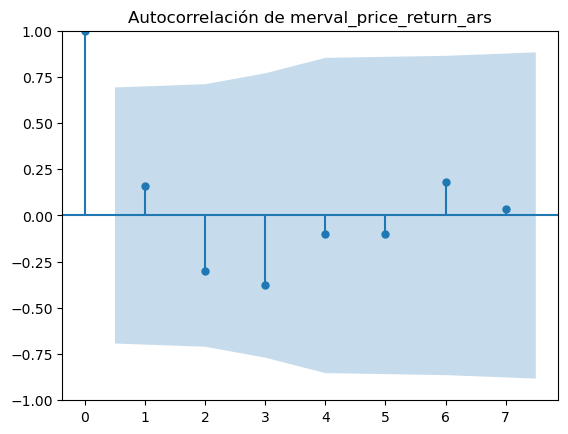

<Figure size 1000x400 with 0 Axes>

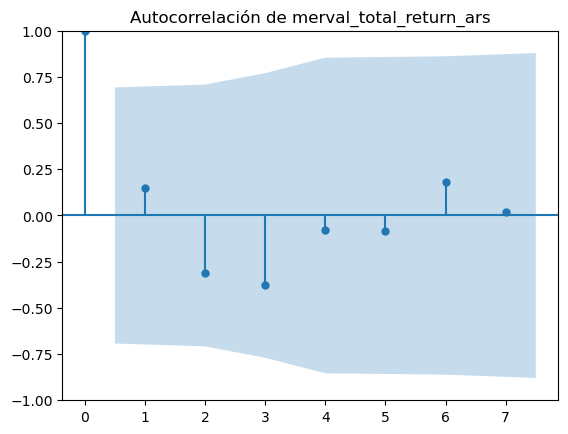

<Figure size 1000x400 with 0 Axes>

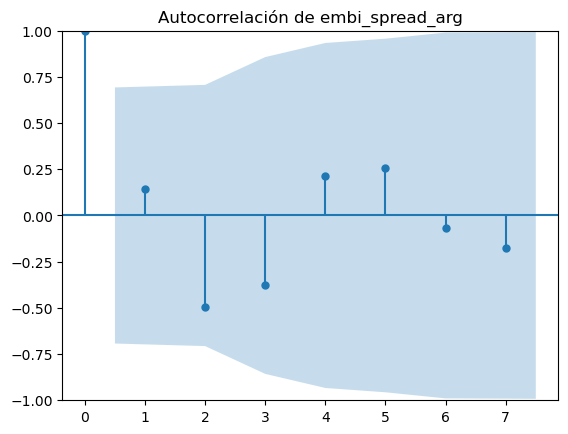

<Figure size 1000x400 with 0 Axes>

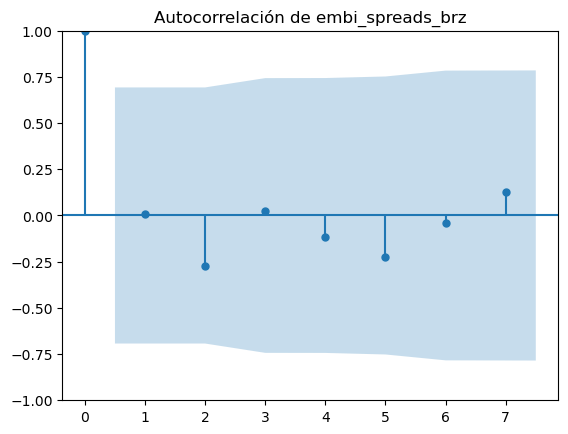

<Figure size 1000x400 with 0 Axes>

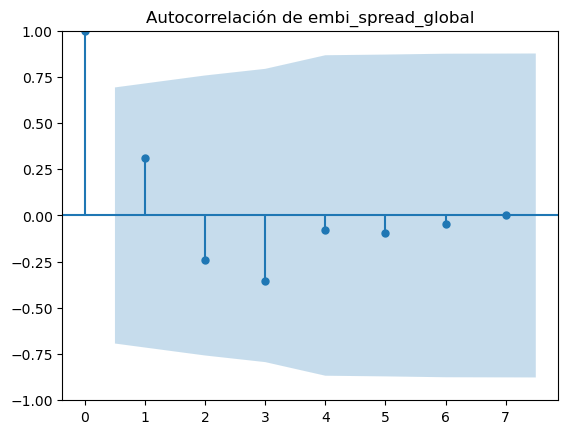

<Figure size 1000x400 with 0 Axes>

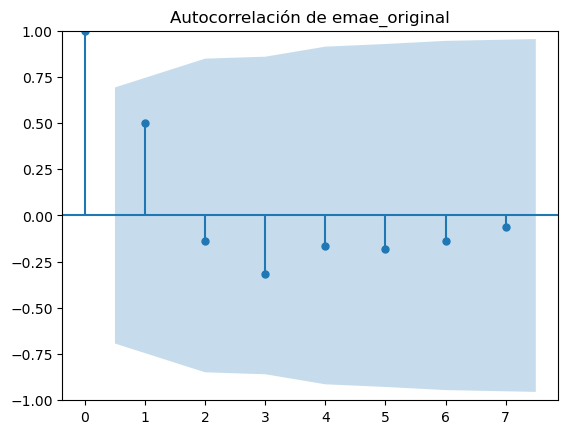

<Figure size 1000x400 with 0 Axes>

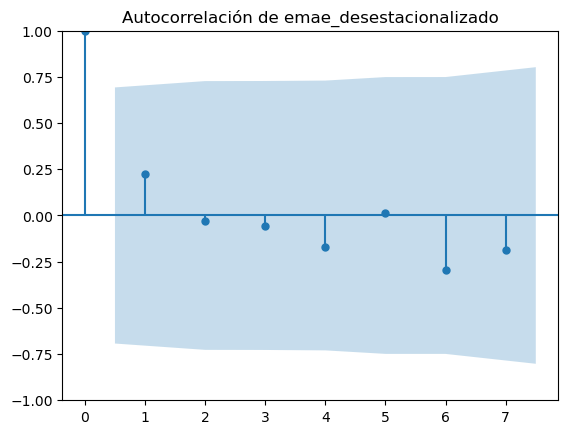

<Figure size 1000x400 with 0 Axes>

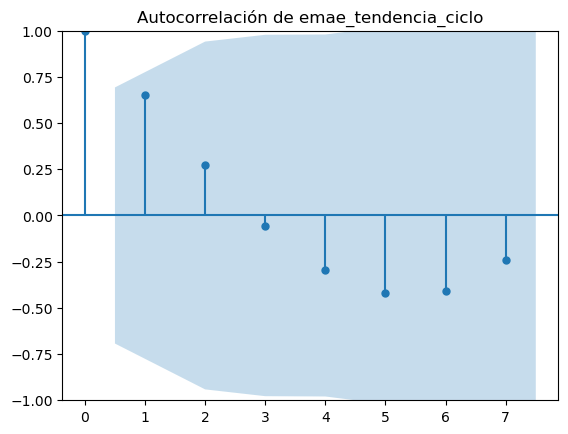

<Figure size 1000x400 with 0 Axes>

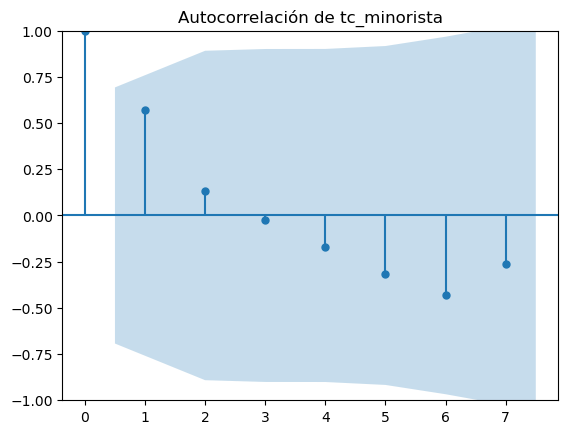

<Figure size 1000x400 with 0 Axes>

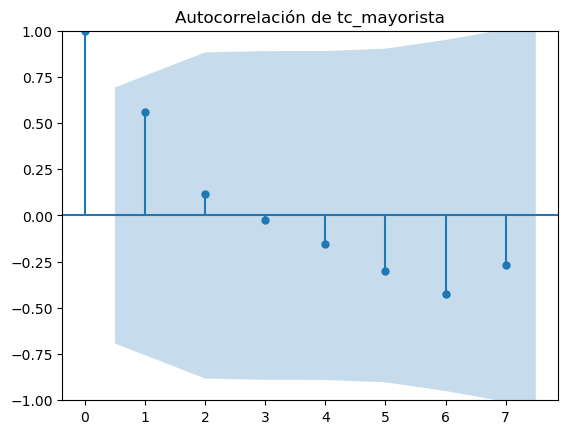

<Figure size 1000x400 with 0 Axes>

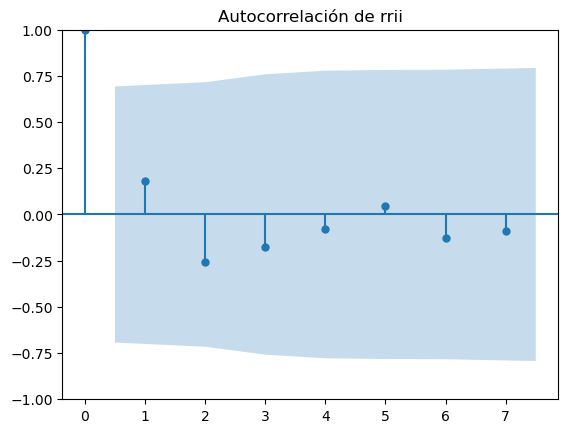

<Figure size 1000x400 with 0 Axes>

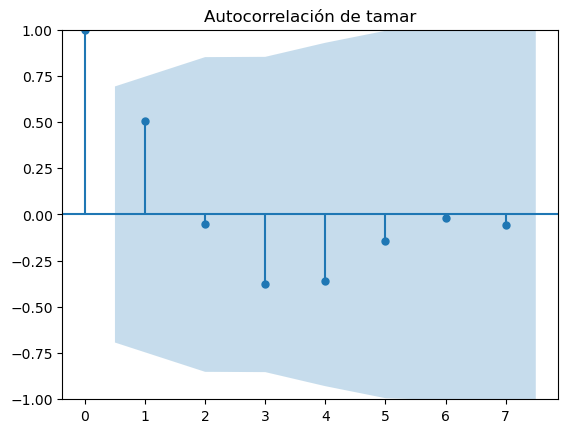

<Figure size 1000x400 with 0 Axes>

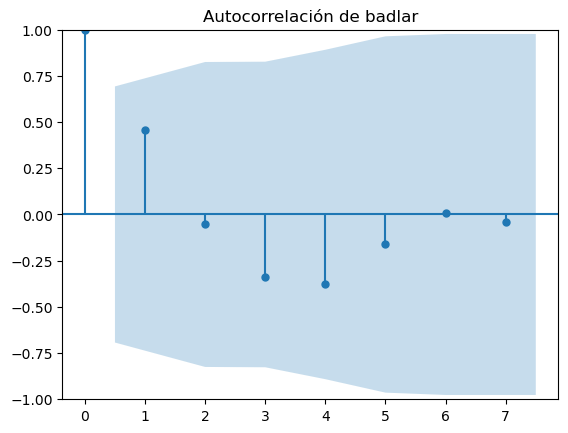

<Figure size 1000x400 with 0 Axes>

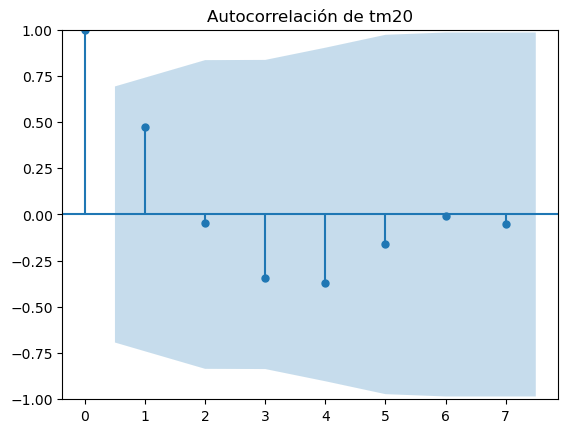

<Figure size 1000x400 with 0 Axes>

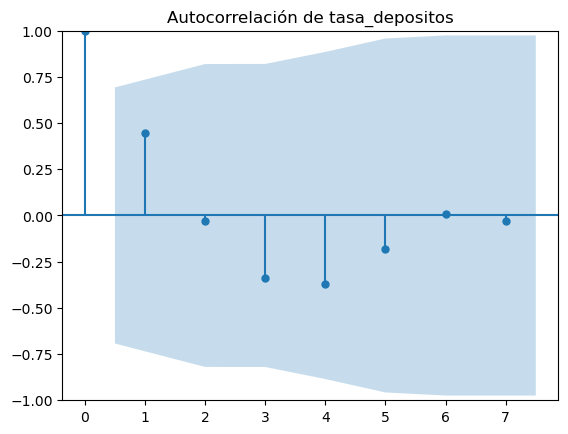

<Figure size 1000x400 with 0 Axes>

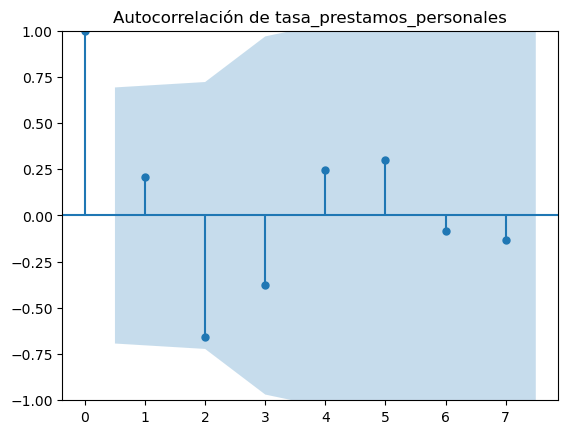

<Figure size 1000x400 with 0 Axes>

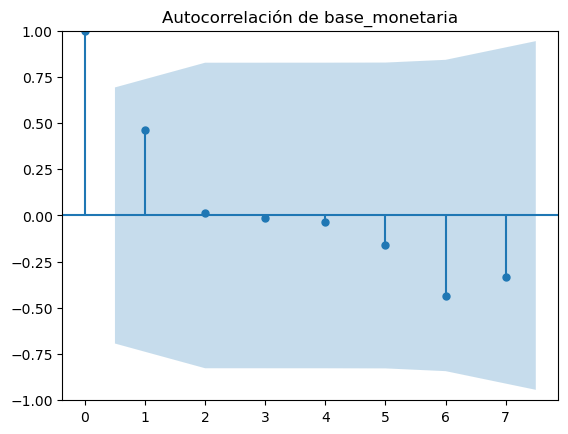

<Figure size 1000x400 with 0 Axes>

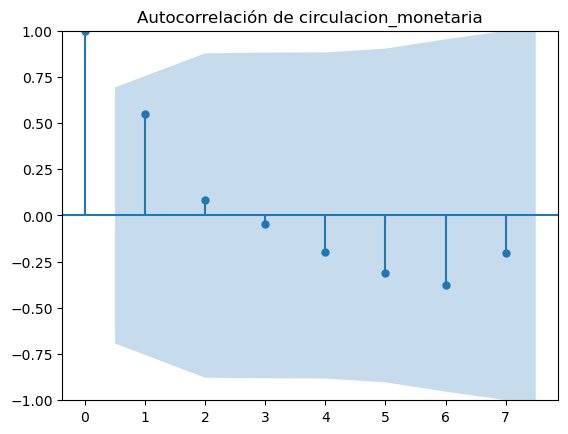

<Figure size 1000x400 with 0 Axes>

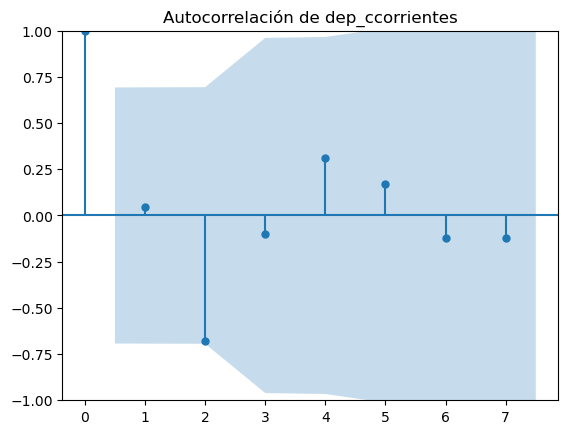

<Figure size 1000x400 with 0 Axes>

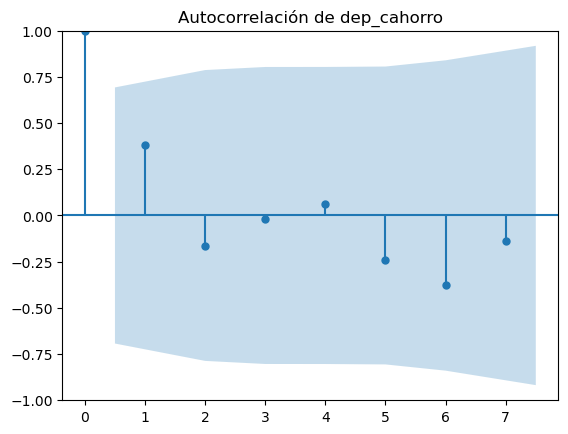

<Figure size 1000x400 with 0 Axes>

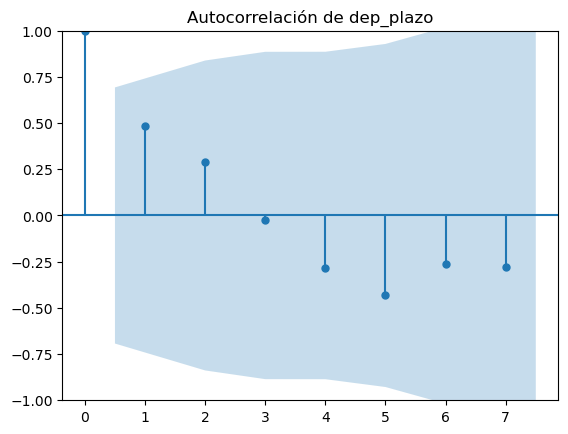

<Figure size 1000x400 with 0 Axes>

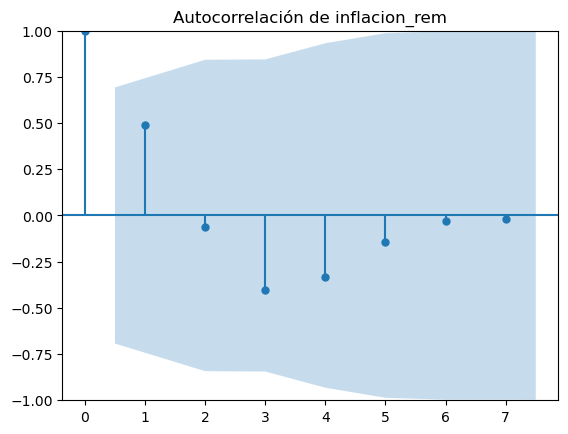

<Figure size 1000x400 with 0 Axes>

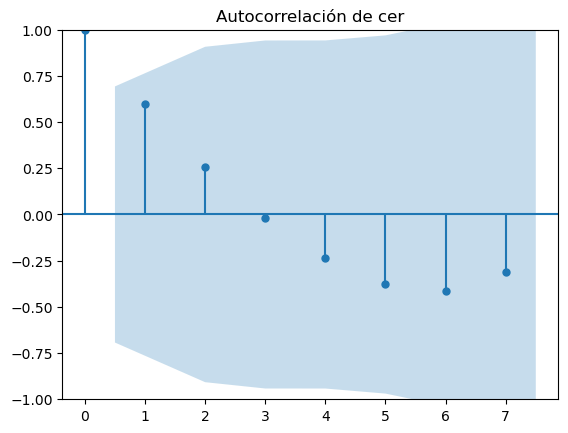

<Figure size 1000x400 with 0 Axes>

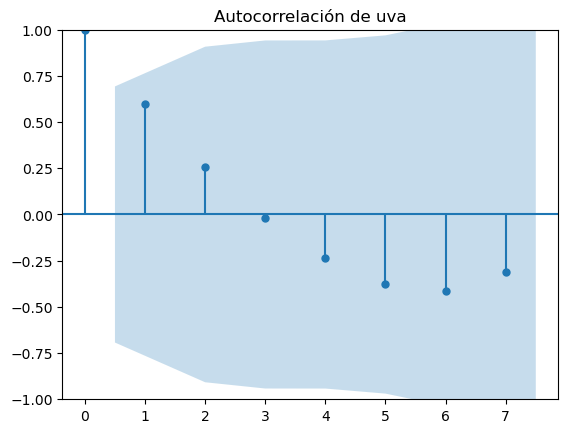

In [38]:
#1. Interpolo las series temporales.
series_interpoladas = {}

for _, row in diccionario.iterrows():
    var = row['serie']
    freq_type = row['frecuencia']  # 'diaria' o 'mensual'
    
    #a. Extraigo la serie
    y = series_temporales[['fecha', var]].copy().set_index('fecha')
    
    #b. Reindexo según la frecuencia
    if freq_type == 'diaria':
        y = y.asfreq('D')
    elif freq_type == 'mensual':
        y = y.asfreq('M')
    
    #c. Interpolación lineal
    y_filled = y.interpolate(method='linear')
    
    #d. Guardo la serie interpolada
    series_interpoladas[var] = y_filled[var]

#2. Combino todas las ST en un único DF.
df_all = pd.DataFrame(series_interpoladas)
df_all = df_all.dropna()  # elimino NA residuales.

#3. Calculo autocorrelaciones con lags.
for var in df_all.columns:
    serie = df_all[var]
    max_lags = min(30, len(serie)-1)  # lags no puede superar tamaño de la serie - 1
    if max_lags <= 0:
        print(f"No hay suficientes datos para {var}")
        continue
    
    plt.figure(figsize=(10,4))
    plot_acf(serie, lags=max_lags)
    plt.title(f"Autocorrelación de {var}")
    plt.show()

#### F. Correlación de todas las ST respecto al precio del Merval.

C:\Users\i_link\AppData\Local\Temp\ipykernel_41932\2527374329.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y = y.asfreq('M')
C:\Users\i_link\AppData\Local\Temp\ipykernel_41932\2527374329.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y = y.asfreq('M')
C:\Users\i_link\AppData\Local\Temp\ipykernel_41932\2527374329.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y = y.asfreq('M')
C:\Users\i_link\AppData\Local\Temp\ipykernel_41932\2527374329.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y = y.asfreq('M')


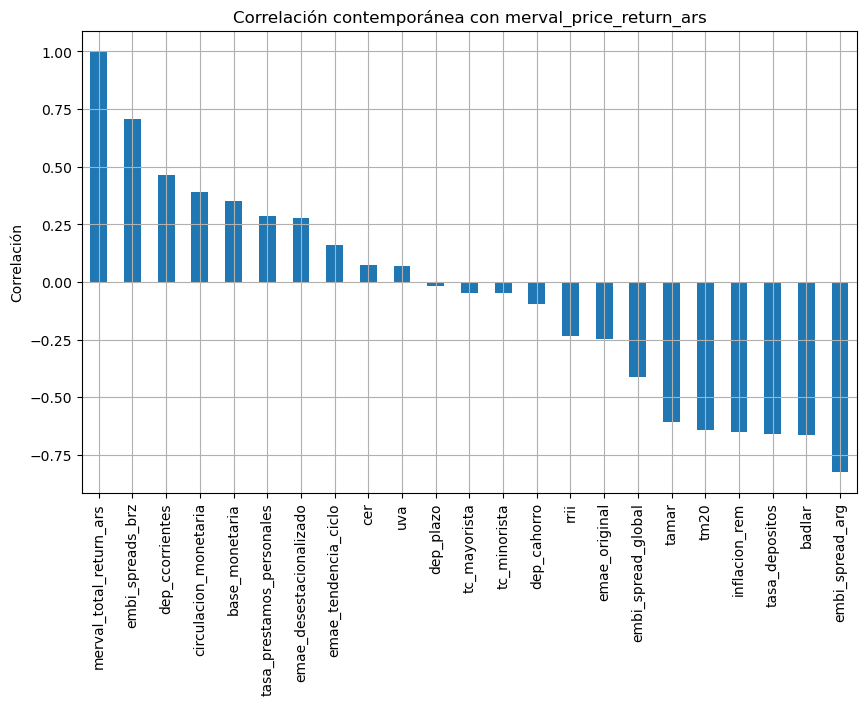

c:\Users\i_link\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\i_link\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\i_link\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


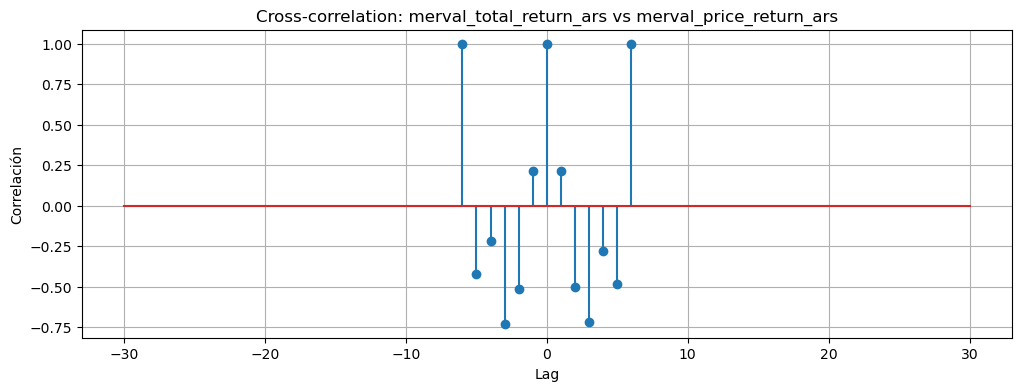

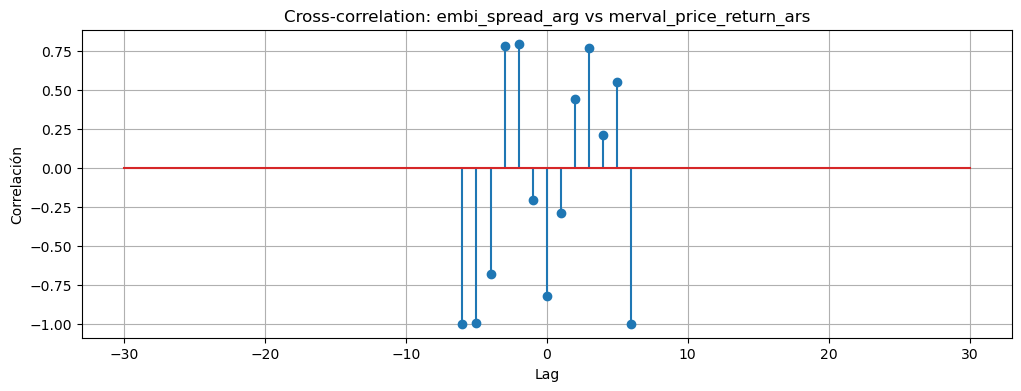

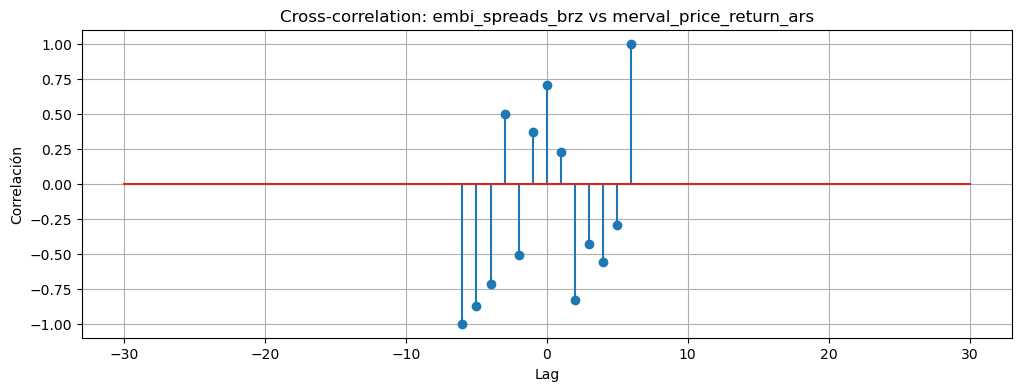

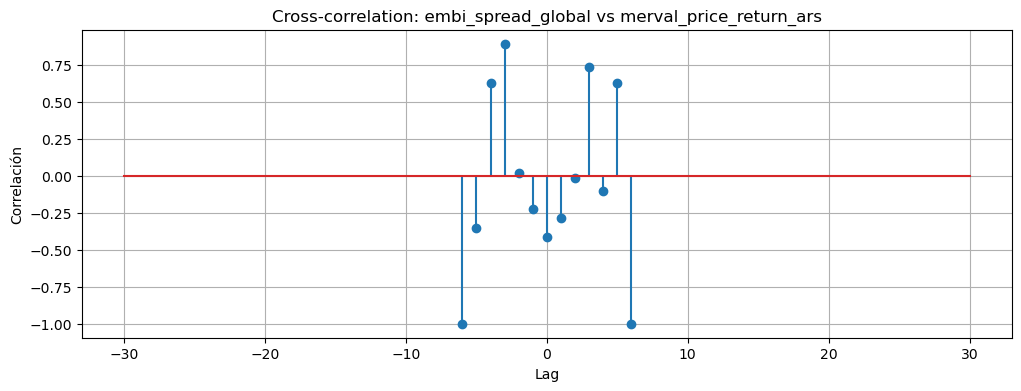

c:\Users\i_link\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\i_link\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


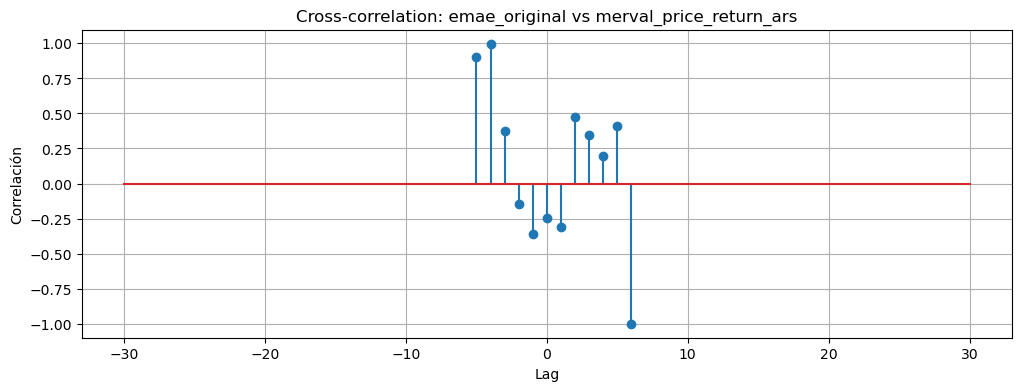

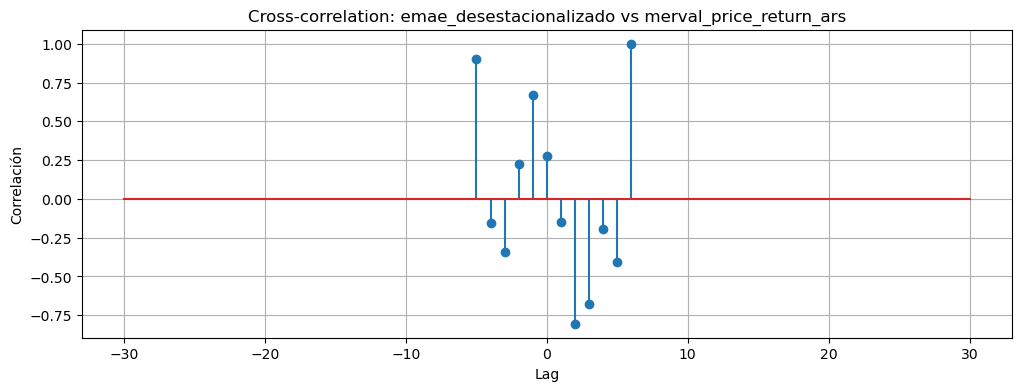

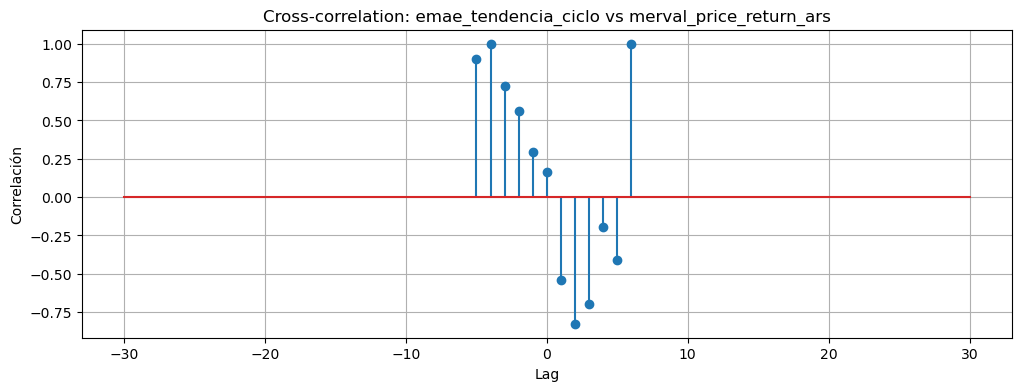

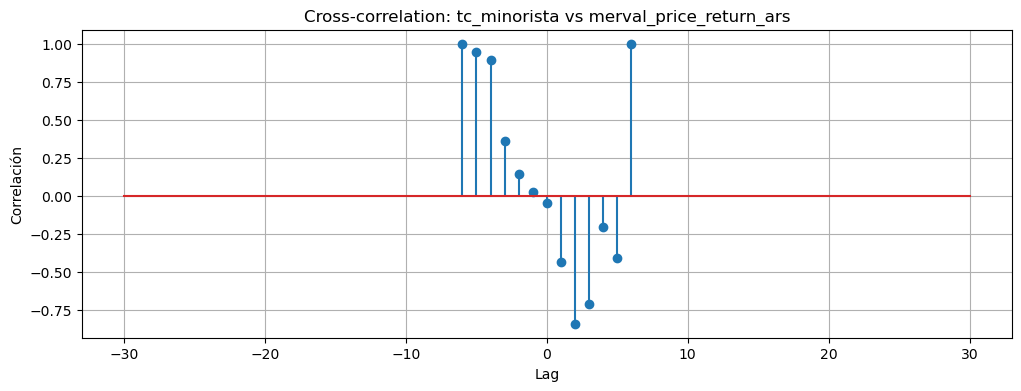

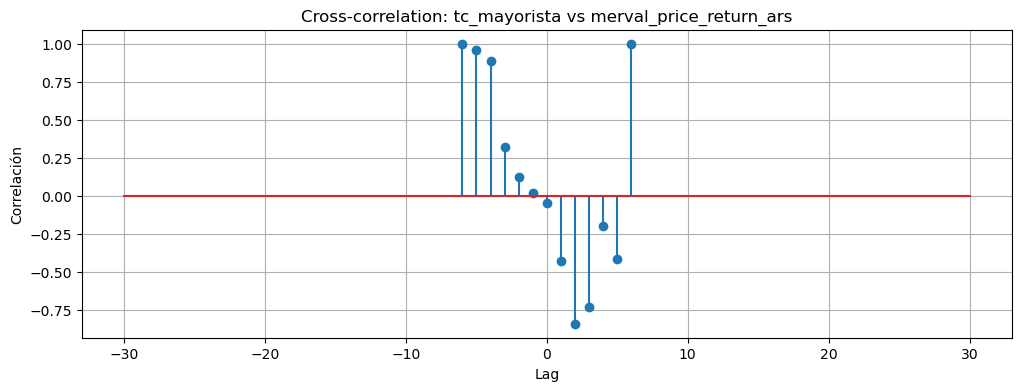

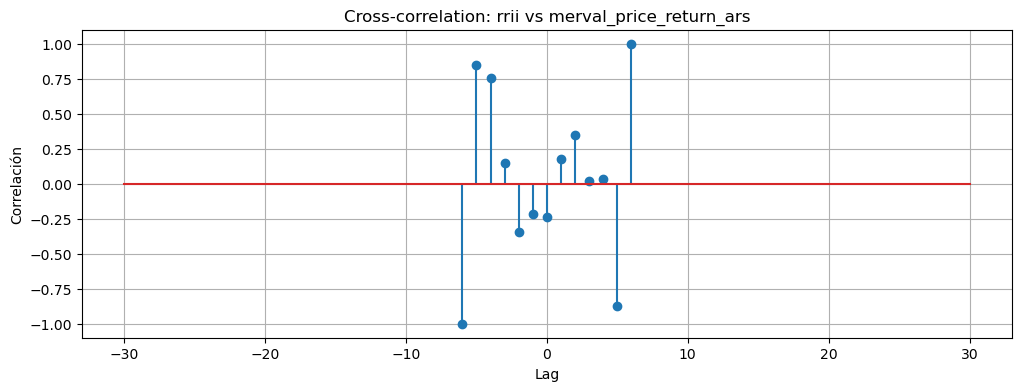

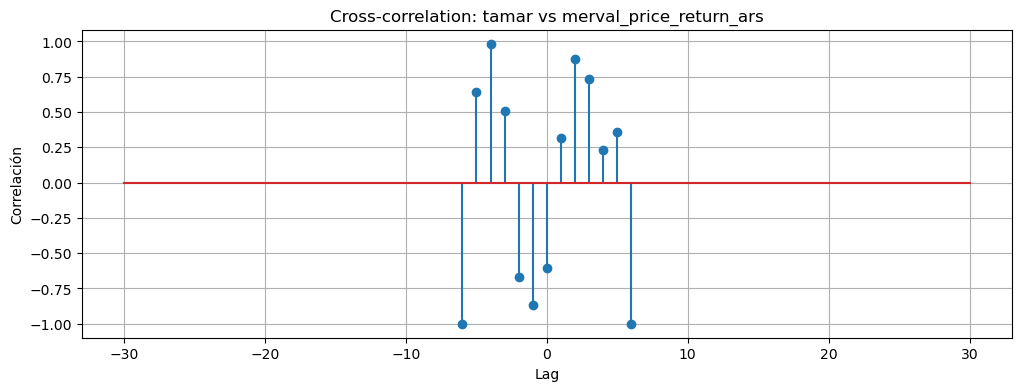

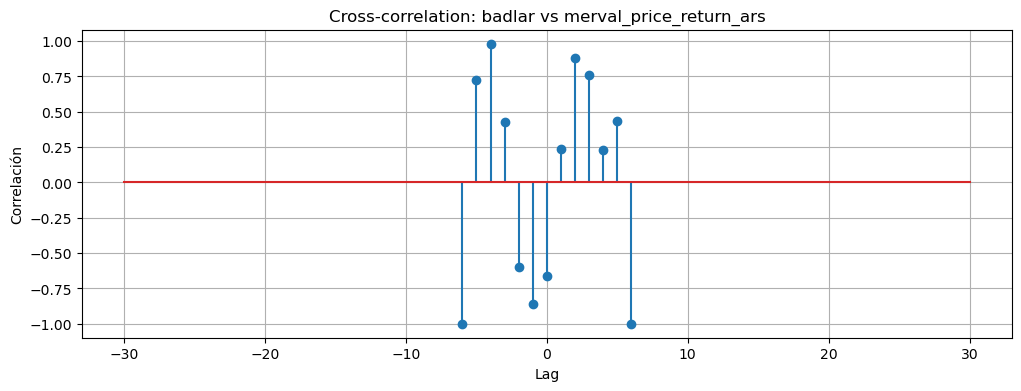

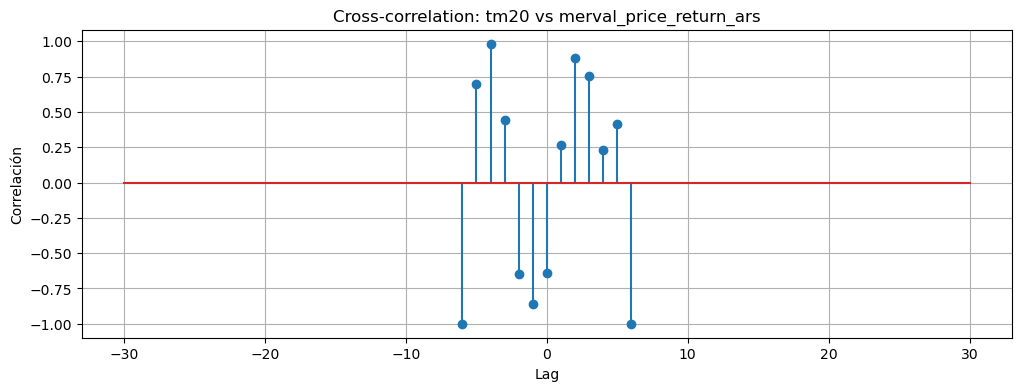

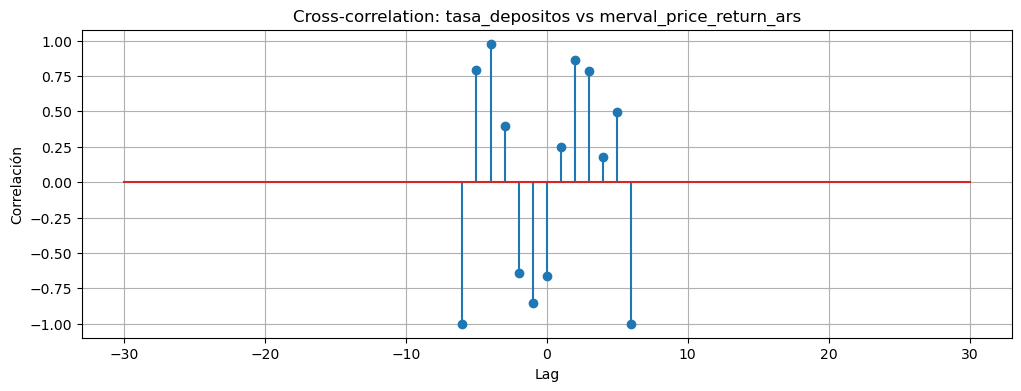

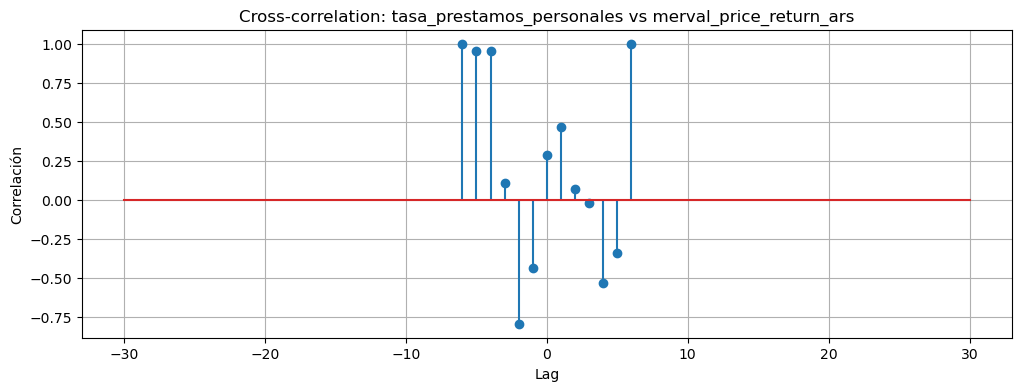

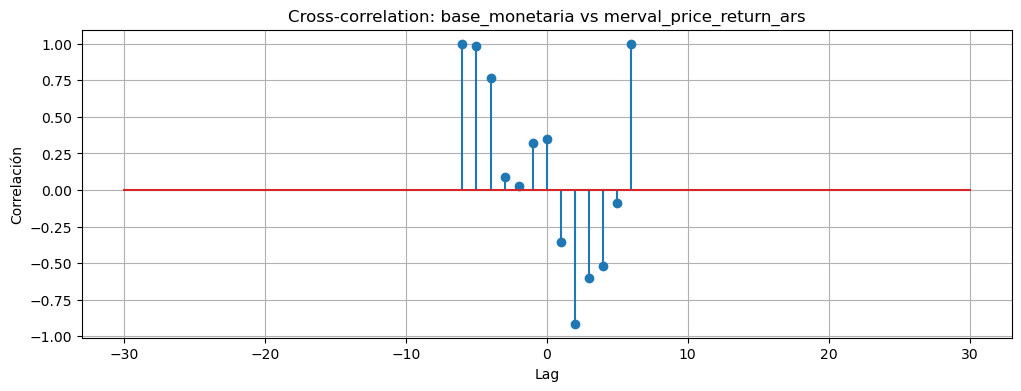

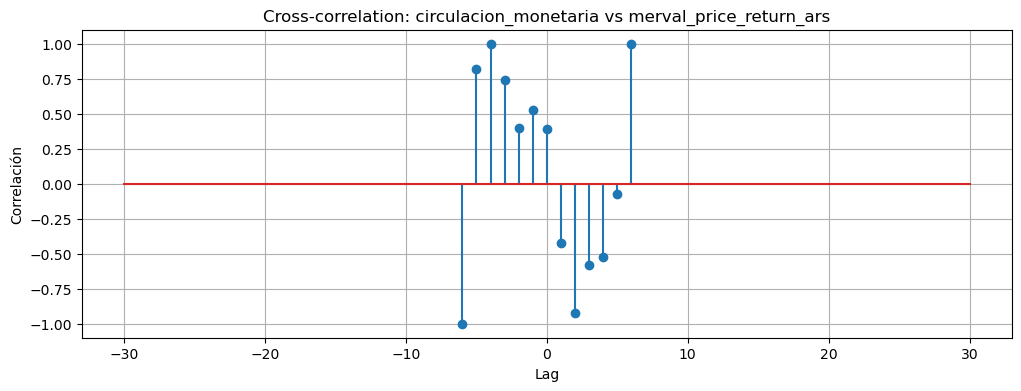

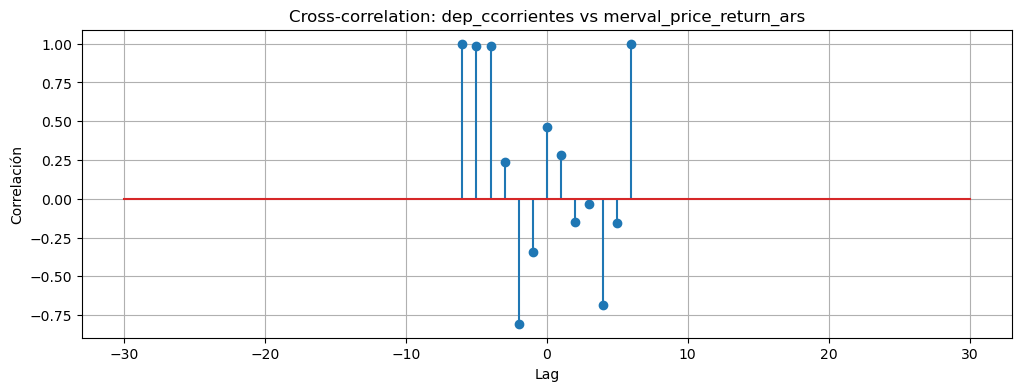

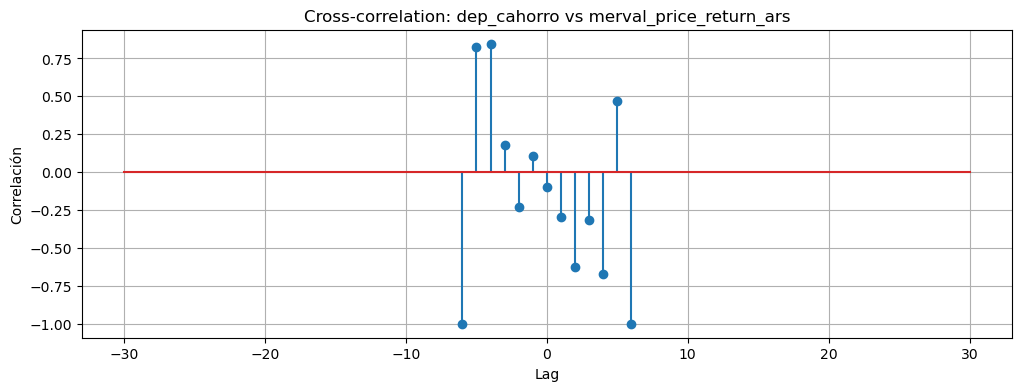

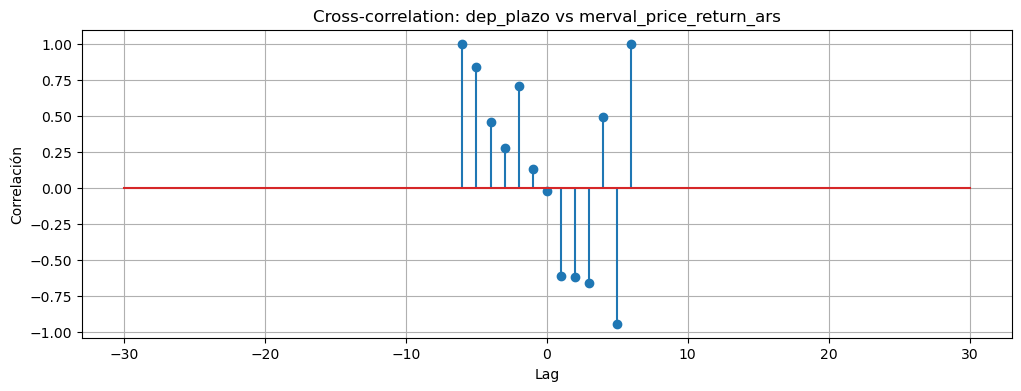

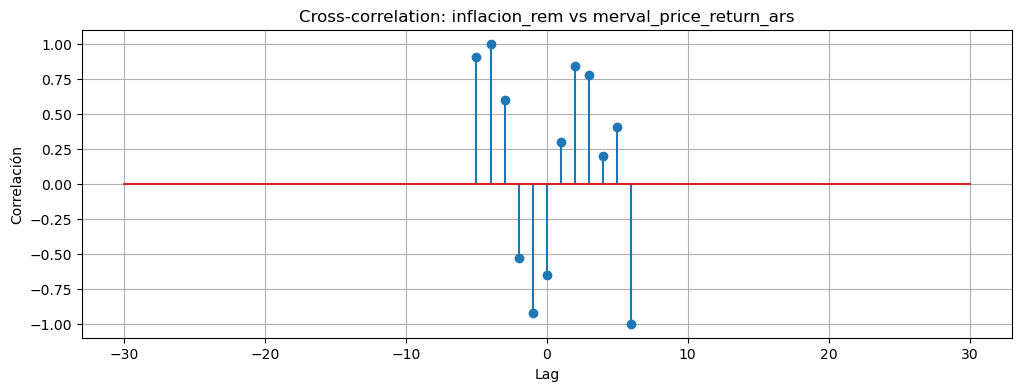

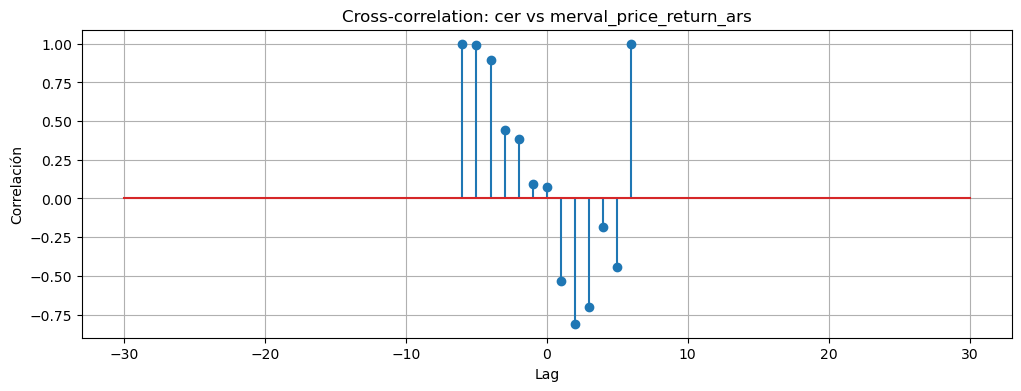

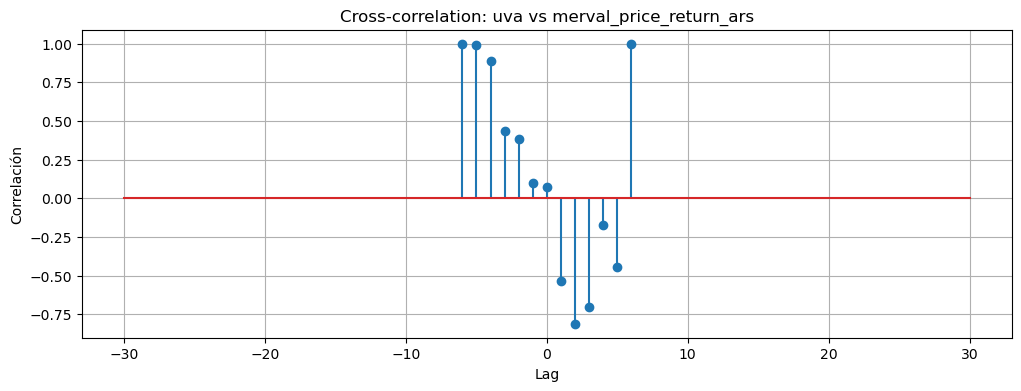

In [33]:
#1. Creamos un diccionario para guardar series interpoladas.
series_interpoladas = {}

#2. Recorremos todas las series y entendemos su frencuencia.
for _, row in diccionario.iterrows():
    var = row['serie']
    freq_type = row['frecuencia']  # 'diaria' o 'mensual'
    
    #a. Extraigo la serie.
    y = series_temporales[['fecha', var]].copy().set_index('fecha')
    
    #b. Reindexo según la frecuencia.
    if freq_type == 'diaria':
        y = y.asfreq('D')
    elif freq_type == 'mensual':
        y = y.asfreq('M')
    
    #c. Interpolación lineal.
    y_filled = y.interpolate(method='linear')
    
    #d. Guardo la serie interpolada.
    series_interpoladas[var] = y_filled[var]

#3. Combinamos todas las series en un único DataFrame.
df_all = pd.DataFrame(series_interpoladas)

#4. Alineo fechas y elimino filas con NA residuales.
df_all = df_all.dropna()

#5. Calculo correlación con merval_price_return_ars.
#a. Correlación contemporánea (lag 0).
correlations = df_all.corr()['merval_price_return_ars'].sort_values(ascending=False)
plt.figure(figsize=(10,6))
correlations.drop('merval_price_return_ars').plot(kind='bar')
plt.title("Correlación contemporánea con merval_price_return_ars")
plt.ylabel("Correlación")
plt.grid(True)
plt.show()

#b. Cross-correlation con lags (!= 0).
lags = 30
for var in df_all.columns:
    if var == 'merval_price_return_ars':
        continue
    cross_corr = [df_all['merval_price_return_ars'].corr(df_all[var].shift(lag)) for lag in range(-lags, lags+1)]
    plt.figure(figsize=(12,4))
    plt.stem(range(-lags, lags+1), cross_corr)
    plt.title(f"Cross-correlation: {var} vs merval_price_return_ars")
    plt.xlabel("Lag")
    plt.ylabel("Correlación")
    plt.grid(True)
    plt.show()